# Insurance Versus Incentives

This notebook simulates the models discussed in Chapter 21 of *Recursive Macroeconomic Theory* (RMT). These models study a planner who designs an efficient contract to supply insurance in the presence of incentive constraints imposed by his limited ability either to enforce a contract or to observe households' actions or incomes.

For all three environments discussed, the household's have a utility function: $u(c) = - \gamma^{-1} \exp(-\gamma c)$. We set $\gamma = 0.8$, and the discount factor, $\beta$ to 0.92. The households have an iid endowment stream, which can take any integer in the range $[\bar y_1,...,\bar y_{10}] = [6,...,15]$. The probability of each realisation is $\Pi_s = \frac{1-\lambda}{1-\lambda^{10}}\lambda^{s-1}$ with $\lambda = \frac{2}{3}$.

A benchmark case is the complete markets environment. As all households are *ex ante* identical, each household would consumer the per capita endowment in every period, and its lifetime utility would be:

$$ v_{pool} = \frac{1}{1-\beta} u \left( \sum_{s=1}^S \Pi_s \bar y_s \right) =  \frac{u(c_{pool})}{1-\beta} $$

Later we will compare the consumption paths for each enviroment to that which would occur in the complete markets environment.

## Environment (a)

The first environment is one in which the moneylender is committed but villagers are unable to commit. At any time households are free to walk away from an arrangement with the moneylender and live in perpetual autarky thereafter. RMT shows how this problem can be written in a recursive form.

Equations 21.3.4 to 21.3.8 in RMT document the moneylender's problem:
\begin{align}
	&P(v) = \max_{c_s,w_s} \sum_{s=1}^S \Pi_s \left[ (\bar y_s - c_s) + \beta P(w_s) \right] \\
	&\text{s.t.} \\
	&\sum_{s=1}^S \Pi_s \left[ u(c_s) + \beta w_s \right] \geq v \\
	&u(c_s) + \beta w_s \geq u(\bar y_s) + \beta v_{aut} \text{ , s = 1,...,S} \\
	&c_s \in [c_{min},c_{max}] \\
	&w_s \in [v_{aut},\bar v]
\end{align}

where $w_s$ is the promised value with which the consumer will enter the next period, given that $y = \bar y_s$ this period. The first constraint is a promise keeping constraint, while the second set of constraints are participation constraints. $[c_{min},c_{max}]$ is a bounded set, while $\bar v$ just needs to be a very large number. The value of autarky to the households is:

$$ v_{aut} = \frac{1}{1-\beta} \sum_{s=1}^S \Pi_s u(\bar y_s) $$

Below we solve the moneylender's problem in this environment using Value Function Iteration. In particular, we approximate $P(v)$ using Chebyshev polynomials. This uses the CompEcon and BasisMatrices packages in Julia. For each iteration, the moneylender's constrained maximization is solved using the NLopt package.

In [1]:
using CompEcon
using BasisMatrices
using NLopt
using StatsBase
using Plots
using Roots

In [2]:
# Parameter values and functions
gamma    = 0.8
beta     = 0.92
u(c)     = -gamma^(-1)*exp(-gamma*c)
u_inv(c) = log(-gamma*c)/(-gamma)
y_grid   = linspace(6,15,10)
y_grid   = reshape(y_grid,10,1)
lamb     = 2/3

# Probability vector
probs    = zeros(10,1)
for i = 1:10
    probs[i] = (1 - lamb)*lamb^(i-1)/(1-lamb^10)
end

# Complete markets consumption
c_pool = probs'*y_grid

# Autarky utility
v_aut = 1/(1-beta)*probs'*u(y_grid);

In [3]:
# Bounds for environment (a) solution
v_max = 1/(1-beta)*u(c_pool+2)
v_min = v_aut
c_min = y_grid[1]
c_max = y_grid[10];

# Use order n Chebyshev approximation for P(v)
n      = 35                  
basis1 = fundefn(:cheb, n, v_min, v_max)  

# Compute the initial approximation of the P function
x1      = funnode(basis1)[1]
x_guess = v_min[1] + (v_max[1] - v_min[1])*linspace(0,1,100)
y       = (c_pool[1] - u_inv(x_guess*(1-beta)))/(1-beta)
coeff1  = funfitxy(basis1, x_guess, y)[1]

# Set initial guess for optimization
x0        = ones(20)
x0[1:10]  = x0[1:10]*c_min
x0[11:20] = x0[11:20]*v_aut

# Define objective function and constraints
Profit(x,grad) = (probs'*(y_grid - x[1:10] + beta*funeval(coeff1, basis1, x[11:20])[1]))[1]

function constraint(x,index,v0)
    fun = [u(y_grid[:]) + beta*v_aut[1] - u(x[1:10]) - beta*x[11:20];v0 - probs'*(u(x[1:10]) + beta*x[11:20])]
    fun[index]
end        

constraint (generic function with 1 method)

In [4]:
# Value function Iteration
diff = 1
tol = 1e-6

# Use NLopt to solve each maximization
opt = Opt(:LN_COBYLA, 20)
lower_bounds!(opt,[ones(10)*c_min[1];ones(10)*v_min[1]])
upper_bounds!(opt,[ones(10)*c_max[1];ones(10)*v_max[1]])
xtol_rel!(opt,1e-4)
max_objective!(opt, Profit)
v0 = x1[1]
for j = 1:11
    inequality_constraint!(opt, (x,g) -> constraint(x,j,v0), 1e-8)
end

while diff > tol
    P_iter = zeros(n,1)
    for i = 1:n
        v0 = x1[i]
        P_iter[i] = optimize(opt,x0)[1]
    end
    c2 = funfitxy(basis1, x1, P_iter)[1]
    diff = maximum(abs(coeff1 - c2))
    coeff1 = c2
end


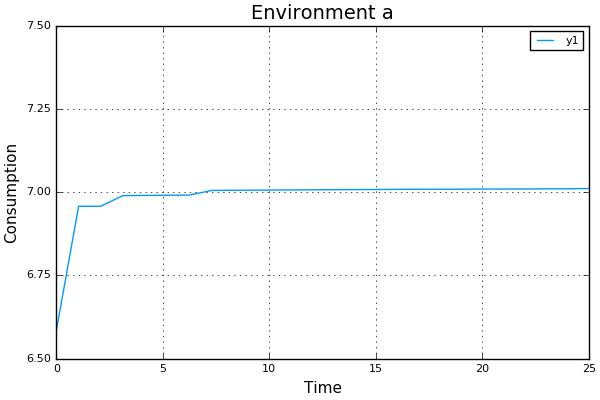

In [5]:
# Simulate time series for environment (a)
T = 25
srand(5) # set seed
y_series = sample(y_grid,WeightVec(probs[:]),T,replace=true,ordered=false)
c_series = zeros(T)
w_series = zeros(T)

v0 = v_aut[1]
x_sol = optimize(opt,x0)[2]
c_series[1] = x_sol[findfirst(y_grid, y_series[1])]
w_series[1] = x_sol[10 + findfirst(y_grid, y_series[1])]

for t = 2:T
    v0 = w_series[t-1]
    x_sol = optimize(opt,x0)[2]
    c_series[t] = x_sol[findfirst(y_grid, y_series[t])]
    w_series[t] = x_sol[10 + findfirst(y_grid, y_series[t])]
end

plot(linspace(0, T, T), c_series, title = "Environment a", xlab = "Time", ylab = "Consumption", ylims = (6.5,7.5))

The above simulation is equivalent to Figure 21.2.1.a in RMT. The discussion in the text confirms that the household's consumption ratchets upwards over time. The consumption level is constant after the first time that the household receives the highest possible endowment.

## Environment (b)

The second environment is one in which households *can* make commitments to enter into binding contracts with the moneylender, but they have private information about their incomes. Consequently, incentive compatability constraints are required to ensure that households truthfully report their incomes. Equations 21.5.1 to 21.5.5 in RMT document the moneylender's problem. 

\begin{align}
	&P(v) = \max_{b_s,w_s} \sum_{s=1}^S \Pi_s \left[ -b_s + \beta P(w_s) \right] \\
	&\text{s.t.} \\
	&\sum_{s=1}^S \Pi_s \left[ u(\bar y_s + b_s) + \beta w_s \right] = v \\
	& C_{s,k} \equiv u(\bar y_s + b_s) + \beta w_s - [ u(\bar y_s + b_k) + \beta w_k ] \geq 0 \hspace{2mm} \forall \hspace{2mm} s,k \in S \times S\\
	&b_s \in [a - \bar y_s,\infty ] \\
	&w_s \in [- \infty, v_{max}]
\end{align}

Here $b_s$ is the transfer that the moneylender gives to a household who reports income $y_s$ if their promised value was $v$. The promise keeping constraint remains, while the participation constraint has been replaced by a large set of incentive compatibility constraints. RMT shows that we can discard many of the incentive compatibility constraints. In solving the model below, we keep only the local upward and downward incentive compatibility constraints.

Again, we solve this problem by Value Function Iteration. Figure 21.5.1 in RMT gives a sketch of the shape of the moneylender's value function for this problem. As can be seen in that figure, the value function displays a lot of curvature as $v \to v_{max}$. Consequently, this makes approximating it quite difficult.

We set $\bar v$ to be $\frac{u(c_{pool} + 2)}{1 - \beta}$. This is high enough to simulate the model, but not so high that it hinders approximation of the value function. It is impractical to set $\bar v$ to be $v_{max}$ as the text shows that $\lim_{v \to v_{max}} P(v) = -\infty$.

In [6]:
# Bounds for environment (b) solution
b_min = - Inf
b_max = Inf
w_min = - Inf
w_max = u(y_grid[10])/(1-beta)
v_min = -1
v_max = u(c_pool[1] + 2)/(1-beta)

v = 0
b_find(b) = (v - probs'*u(y_grid + b)/(1-beta))[1]

# Use order n Chebyshev approximation for P(v) 
n      = 25
basis2 = fundefn(:cheb, n, v_min, v_max)  
x2     = funnode(basis2)[1]

# Get good initial guess of P(v) from the text
check_grid = v_min + (v_max - v_min)*linspace(0,1,100)
cbar = zeros(100)
upper = zeros(100)
bbar = zeros(100)
lower = zeros(100)
for i = 1:100
    cbar[i] = u_inv((1-beta)*check_grid[i])
    upper[i] = (probs'*(y_grid - cbar[i])/(1-beta))[1]
    v = check_grid[i]
    bbar[i] = fzero(b_find,-10,10)
    lower[i] = -bbar[i]/(1-beta)
end
coeff2 = funfitxy(basis2, check_grid, 0.9*upper + 0.1*lower)[1]

# Bounds for maximization stage
opt2 = Opt(:LN_COBYLA, 20)
lower_bounds!(opt2,[ones(10)*b_min[1];ones(10)*w_min[1]])
upper_bounds!(opt2,[ones(10)*b_max[1];ones(10)*w_max[1]])

# Define objective function and constraints
Profit2(x,grad) = (probs'*(- x[1:10] + beta*funeval(coeff2, basis2, x[11:20])[1]))[1]

function constraint2(x,v0)
    fun = -v0 + probs'*(u(y_grid + x[1:10]) + beta*x[11:20])
    fun[1]
end

function constraint3(x,index)
    fun = [u(y_grid[2:10] + x[1:9]) + beta*x[11:19] - u(y_grid[2:10] + x[2:10]) - beta*x[12:20]; u(y_grid[1:9] + x[2:10]) + beta*x[12:20] - u(y_grid[1:9] + x[1:9]) - beta*x[11:19]]
    fun[index]
end

max_objective!(opt2, Profit2)
xtol_rel!(opt2,1e-4)
v0 = x2[1]
equality_constraint!(opt2, (x,g) -> constraint2(x,v0))
for j = 1:18
    inequality_constraint!(opt2, (x,g) -> constraint3(x,j))
end

#Initialize guess of x
x0   = zeros(20);
for i = 1:10
    x0[i] = 3-i
end

In [7]:
# Value function iteration
diff = 1
tol = 1e-6
while diff > tol
    P_iter = zeros(size(x2)[1],1)
    for i = 1:size(x2)[1]
        v0 = x2[i]
        for j = 11:20
            x0[j] = v0;
        end
        P_iter[i] = optimize(opt2,x0)[1]
    end
    c2 = funfitxy(basis2, x2, P_iter)[1]
    diff = maximum(abs(coeff2 - c2))
    coeff2 = c2
end


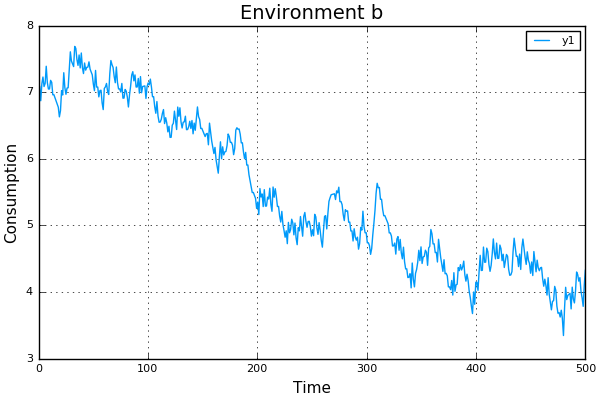

In [8]:
# Simulate time series
T = 500
srand(5)
y_series = sample(y_grid,WeightVec(probs[:]),T,replace=true,ordered=false)
c_series = zeros(T)
w_series = zeros(T)

v0 = v_aut[1]
for j = 11:20
    x0[j] = v0;
end
x_sol = optimize(opt2,x0)[2]
c_series[1] = y_series[1] + x_sol[findfirst(y_grid, y_series[1])]
w_series[1] = x_sol[10 + findfirst(y_grid, y_series[1])]

for t = 2:T
    v0 = w_series[t-1]
    x_sol = optimize(opt2,x0)[2]
    c_series[t] = y_series[t] + x_sol[findfirst(y_grid, y_series[t])]
    w_series[t] = x_sol[10 + findfirst(y_grid, y_series[t])]
end

plot(linspace(0,T,T), c_series, title = "Environment b", xlab = "Time", ylab = "Consumption", ylims = (3,8))

This simulation confirms that in environment (b) the incentive compatibility constraints force the planner to introduce a downward tilt into consumption paths.

## Environment (c)

The third environment is the same as in (b), except for the additional assumption that households have access to a storage tecnology that cannot be observed by the moneylender. The text shows that the solution to this problem is the same as in an economy where each household can borrow or lend outside the village at the risk-free gross interest rate R, subject to the natural debt limit.

We can find the natural debt limit by iterating forward on the households budget constraint:
\begin{equation}
	c + k' = y + Rk
\end{equation}
This iteration gives:
\begin{equation}
	k = \frac{1}{R} \sum_{j=0}^\infty \frac{c - y}{R^j}
\end{equation}
Imposing non-negativity on consumption:
\begin{equation}
	k \geq  - \frac{1}{R} \sum_{j=0}^\infty \frac{y}{R^j}
\end{equation}
Finally, the natural debt limit is found by choosing the lowest possible value of the endowment, so that for any possible endowment stream the household can always pay back its debts:
\begin{equation}
	k \geq  - \frac{1}{R} \sum_{j=0}^\infty \frac{\bar y_{min}}{R^j} = - \frac{\bar y_{min}}{R-1} \equiv \phi
\end{equation}
Using our parameter values: $\phi = - \frac{6}{\frac{1}{0.92} - 1} = -69$. The household's recursive problem is then:
\begin{align}
	&V(k,y) = \max_{c,k'} u(c) + \beta E [V(k',y')] \\
	&\text{s.t.} \\
	&c + k' = y + Rk \\
	& k' \geq \phi
\end{align}
Below we solve this income fluctuation problem using the Endogenous Grid Method.

In [9]:
k_max = 500
R = 1/beta
k_min = -y_grid[1]/(R-1)
k_num = 500
k_grid = linspace(k_min,k_max,500)

u_c(c)     = exp(-gamma*c)
u_c_inv(c) = -log(c)/gamma

tol = 1e-6
change = tol + 1
iteration = 1

# Guess a consumption function
C0 = zeros(k_num,10)
for i = 1:k_num
    for j = 1:10
        C0[i,j] = (R-1)*k_grid[i] + y_grid[j]
    end
end

# Define Function Space
breakpoints = k_min + (k_max - k_min)*linspace(0, 1, 10)'.^2.5
basis3 = fundef((:spli, breakpoints[:], 0, 3))

# EGM iteration
tol     = 1e-6;
change  = tol + 1;
while change > tol;
    # Construct RHS of Euler eqn
    B       = zeros(k_num,10);
    # Solve for \tilde c which solves Euler eqn
    Ct      = zeros(k_num,10);
    # From BC, solve for k*, which is value of assets today to have i tomorrow with income j today   
    kstar   = zeros(k_num,10);
    for i = 1:k_num;
        for j = 1:10;
            B[i,j] = (beta*R*probs'*u_c(C0[i,:]))[1];
            Ct[i,j] = u_c_inv(B[i,j]);
            kstar[i,j] = (Ct[i,j] + k_grid[i] - y_grid[j])/R;
        end
    end
    # Update our guess defined on the original grid
    C1 = zeros(k_num,10);
    for i = 1:k_num;
        for j = 1:10;
            coeff3 = funfitxy(basis3, kstar[:,j], Ct[:,j])[1]
            C1[i,j] = (funeval(coeff3, basis3, [k_grid[i]])[1])[1]
            if R*k_grid[i] + y_grid[j] - C1[i,j] < k_grid[1]
                C1[i,j] = R*k_grid[i] + y_grid[j] - k_grid[1];
            end
        end
    end
    diff = abs(C1 - C0);
    change = maximum(diff);
    C0 = C1;
end


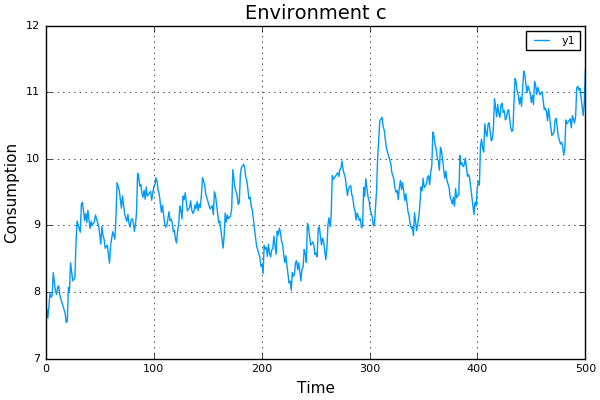

In [10]:
#Simulate using the same endowment path

k_series      = zeros(T+1);
c_series      = zeros(T);
resid_series  = zeros(T);
k_series[1]   = 0;

for i = 1:T;
    y_ind          = findfirst(y_grid,y_series[i])
    coeff3          = funfitxy(basis3, k_grid, C0[:,y_ind])[1]
    c_series[i]    = (funeval(coeff3, basis3, [k_series[i]])[1])[1]
    k_series[i+1]  = R*k_series[i] + y_series[i] - c_series[i];
end

plot(linspace(0,T,T), c_series, title = "Environment c", xlab = "Time", ylab = "Consumption", ylims = (7,12))

The introduction of a storage technology for the household means that the consumption path now has an upward trend. This occurs as our parameter values are such that $\beta R = 1$.